In [11]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
! cp kaggle.json ~/.kaggle/

In [14]:
! chmod 600 ~/.kaggle/kaggle.json


In [15]:
!kaggle datasets download -d sheshngupta/waldowilma

 99% 2.94G/2.97G [00:31<00:00, 137MB/s]
100% 2.97G/2.97G [00:31<00:00, 101MB/s]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model

#import time
import time

In [17]:
import zipfile
import os

In [19]:
from google.colab import files
from zipfile import ZipFile

! unzip waldowilma.zip

Streaming output truncated to the last 5000 lines.
  inflating: generated_images/resized_224x224/resized_image_0.png  
  inflating: generated_images/resized_224x224/resized_image_1.png  
  inflating: generated_images/resized_224x224/resized_image_10.png  
  inflating: generated_images/resized_224x224/resized_image_100.png  
  inflating: generated_images/resized_224x224/resized_image_1000.png  
  inflating: generated_images/resized_224x224/resized_image_1001.png  
  inflating: generated_images/resized_224x224/resized_image_1002.png  
  inflating: generated_images/resized_224x224/resized_image_1003.png  
  inflating: generated_images/resized_224x224/resized_image_1004.png  
  inflating: generated_images/resized_224x224/resized_image_1005.png  
  inflating: generated_images/resized_224x224/resized_image_1006.png  
  inflating: generated_images/resized_224x224/resized_image_1007.png  
  inflating: generated_images/resized_224x224/resized_image_1008.png  
  inflating: generated_images/resiz

In [21]:
from google.colab.patches import cv2_imshow
from skimage import io

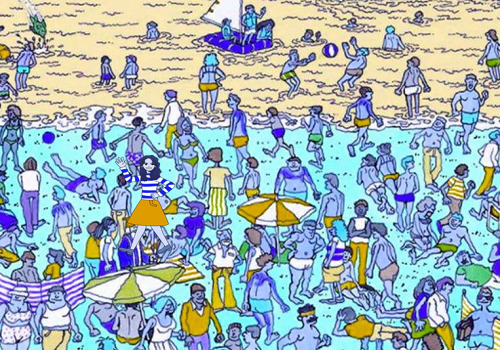

In [22]:
background_dir = "generated_images/charecters/image_0.png"
waldo_dir = "generated_images/charecters/waldo.png" 
wilma_dir = "generated_images/charecters/wilma.png"
image = io.imread(background_dir)
cv2_imshow(image)

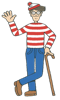

In [23]:
waldo_im = Image.open(waldo_dir)
waldo_im = waldo_im.resize((60, 100))
waldo_im

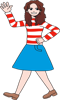

In [24]:
wilma_im = Image.open(wilma_dir)
wilma_im = wilma_im.resize((60, 100))
wilma_im

In [25]:
#create a function to generate images
def generate_sample_image():
    
    #background image
    background_im = Image.open(background_dir)
    background_im = background_im.resize((500, 350))
    #background_im = Image.new("RGB", (500, 350), (255, 255, 255))

    #waldo
    waldo_im = Image.open(waldo_dir)
    waldo_im = waldo_im.resize((60, 100))

    #wilma
    wilma_im = Image.open(wilma_dir)
    wilma_im = wilma_im.resize((60, 100))
    
    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)
    
    #pic randomly between waldo and wilma. If 1 we will select waldo. if 0 we wills elect wilma
    rand_person = np.random.choice([0, 1], p = [0.5, 0.5])
    
    if rand_person == 1:
        
        background_im.paste(waldo_im, (col, row), mask = waldo_im)
        cat = 'Waldo'
        
    else:
        
        background_im.paste(wilma_im, (col, row), mask = wilma_im)
        cat = 'Wilma'
        
    return np.array(background_im).astype('uint8')[:,:,:-1], (col, row), rand_person, cat 

([], [])

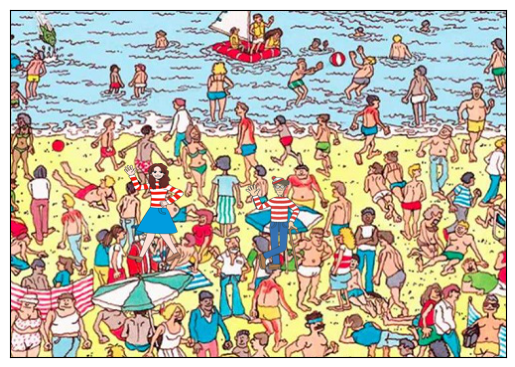

In [26]:
sample_im, pos, _, cat = generate_sample_image()
plt.imshow(sample_im)
plt.xticks([])
plt.yticks([])
##plt.show()

In [27]:
def plot_bounding_box(image, gt_coords, pred_coords = None):
    
    #convert image to array
    image = Image.fromarray(image)    
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)
    
    if pred_coords:
        
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)
    
    return image

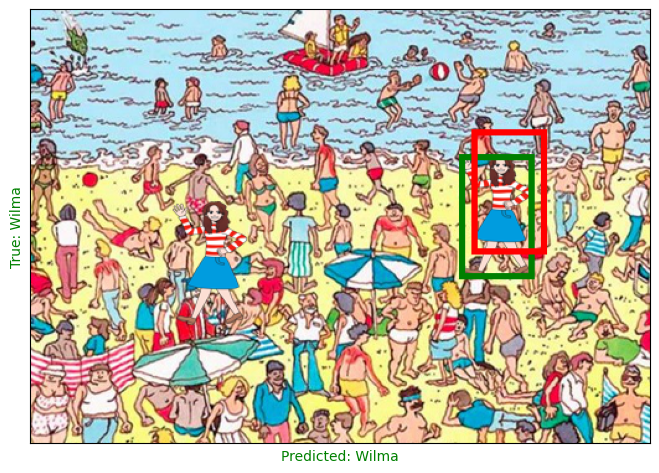

In [28]:
sample_im, pos, _, cat = generate_sample_image()

#get image with bounding box
im = plot_bounding_box(sample_im, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.xlabel('Predicted: ' + cat, color = 'green')
plt.ylabel('True: ' + cat, color = 'green' )
plt.show()

In [29]:
#data generator function 
def generate_data(batch_size = 16):
    
    while True:
        j = 0
        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))
      
        for i in range(batch_size):
            
            #generate an example image
            sample_im, pos, person, _ = generate_sample_image()
            
            #put the images to the arrays
            x_batch[i] = sample_im/255 #normalize
            y_batch[i] = person
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]
            
        yield {'image': x_batch} , {'class': y_batch, 'box': boundary_box}      

In [30]:
#create the model
def convolutional_block(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
        
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    return x

def regression_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

def classification_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'class')(x)
    
    return x

In [31]:
from tensorflow.keras.utils import plot_model
#create the model instance
inputs = tf.keras.Input((350, 500, 3),name='image')

#conv block
x = convolutional_block(inputs)

#outputs
box_output = regression_block(x)
class_output = classification_block(x)

#model instance
model = tf.keras.Model(inputs = inputs, outputs = [class_output, box_output])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 350, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 350, 500, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 350, 500, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [33]:
#custom function to visualize the predictions after epochs
def test_model():
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))    
    
    for i in range(3):
        
        #get sample image
        sample_im, pos, _, cat = generate_sample_image()
        sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
        predicted_class, predicted_box = model.predict(sample_image_normalized)
        
        if predicted_class > 0.5:
            predicted_class = 'Waldo'
        else:
            predicted_class = 'Wilma'
        
        #assign color
        col = 'green' if (predicted_class == cat) else 'red'
        
        #get bounding boxes
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))
        
        #plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel('True: ' + cat, color = 'green')
        ax[i].set_xlabel('Predicted: ' + predicted_class, color = col)
        
    plt.show()
        
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model()
            
#learning rate scheduleer
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

In [34]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'class': 'binary_crossentropy', 'box': 'mse'}, \
              metrics = {'class': 'accuracy', 'box': 'mse'})

Epoch 1/10
1/1 [==============================] - 0s 134ms/step


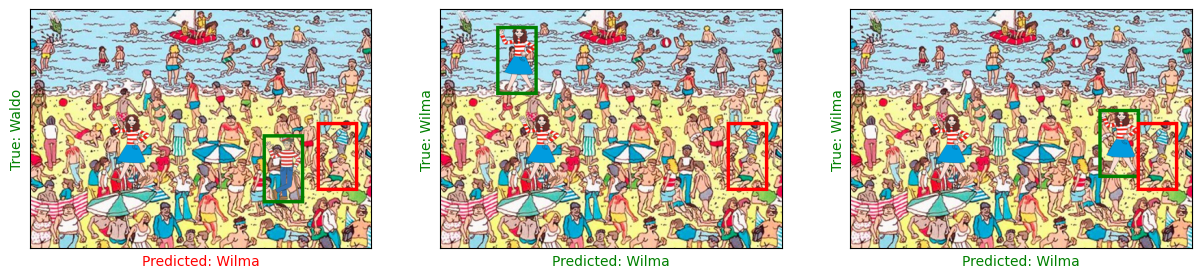

100/100 [==============================] - 851s 8s/step - loss: 3718.2209 - class_loss: 4.1967 - box_loss: 3714.0227 - class_accuracy: 0.4938 - box_mse: 3714.0227 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 808s 8s/step - loss: 106.3216 - class_loss: 0.7351 - box_loss: 105.5865 - class_accuracy: 0.5750 - box_mse: 105.5865 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 145ms/step


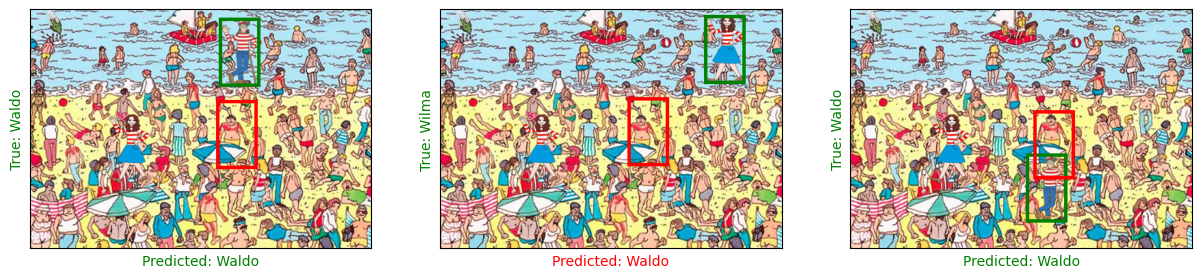

100/100 [==============================] - 813s 8s/step - loss: 125.2573 - class_loss: 0.5413 - box_loss: 124.7160 - class_accuracy: 0.7256 - box_mse: 124.7160 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 825s 8s/step - loss: 81.3018 - class_loss: 0.3733 - box_loss: 80.9285 - class_accuracy: 0.8319 - box_mse: 80.9285 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 127ms/step


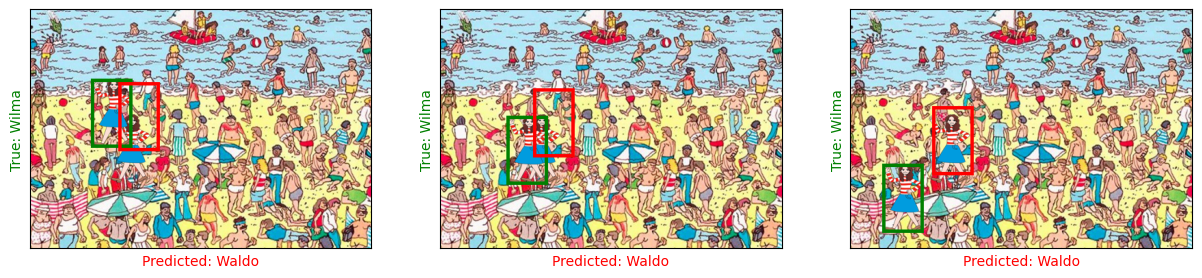

100/100 [==============================] - 818s 8s/step - loss: 28.9824 - class_loss: 0.0519 - box_loss: 28.9305 - class_accuracy: 0.9931 - box_mse: 28.9305 - lr: 2.0000e-04
Epoch 6/10
100/100 [==============================] - 819s 8s/step - loss: 19.3173 - class_loss: 0.0271 - box_loss: 19.2903 - class_accuracy: 0.9969 - box_mse: 19.2903 - lr: 2.0000e-04
Epoch 7/10
1/1 [==============================] - 0s 135ms/step


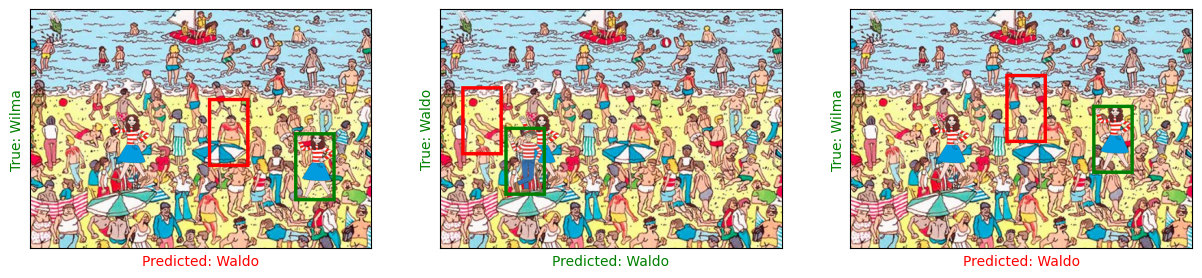

100/100 [==============================] - 814s 8s/step - loss: 19.2835 - class_loss: 0.0306 - box_loss: 19.2529 - class_accuracy: 0.9962 - box_mse: 19.2529 - lr: 2.0000e-04
Epoch 8/10
100/100 [==============================] - 810s 8s/step - loss: 15.2010 - class_loss: 0.0224 - box_loss: 15.1787 - class_accuracy: 0.9987 - box_mse: 15.1787 - lr: 2.0000e-04
Epoch 9/10
1/1 [==============================] - 0s 128ms/step


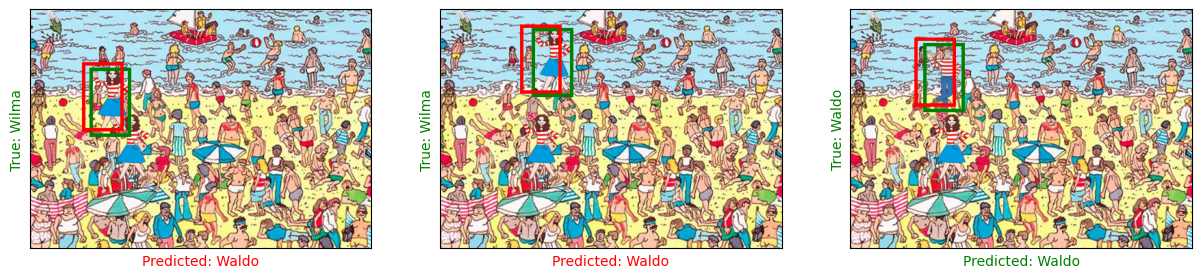

100/100 [==============================] - 811s 8s/step - loss: 16.2487 - class_loss: 0.0266 - box_loss: 16.2221 - class_accuracy: 0.9950 - box_mse: 16.2221 - lr: 2.0000e-04
Epoch 10/10
100/100 [==============================] - 818s 8s/step - loss: 13.5621 - class_loss: 0.0126 - box_loss: 13.5496 - class_accuracy: 0.9975 - box_mse: 13.5496 - lr: 4.0000e-05


In [35]:
#beginning time
tick = time.time()

#fit the model
hist = model.fit(generate_data(), epochs = 10, steps_per_epoch = 100, callbacks = [VisCallback(),tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

#end time
tock = time.time()

In [36]:
#print time taken 
print('Took {} minutes to run finish training 10 epochs'.format(np.round((tock - tick)/60, 2)))

Took 137.45 minutes to run finish training 10 epochs


1/1 [==============================] - 0s 129ms/step


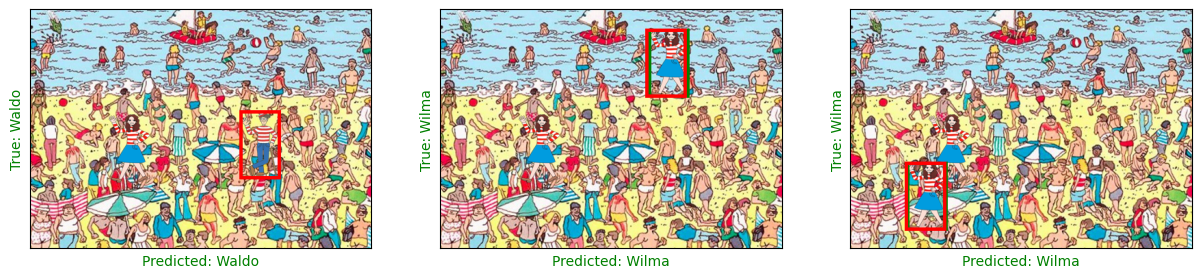

1/1 [==============================] - 0s 126ms/step


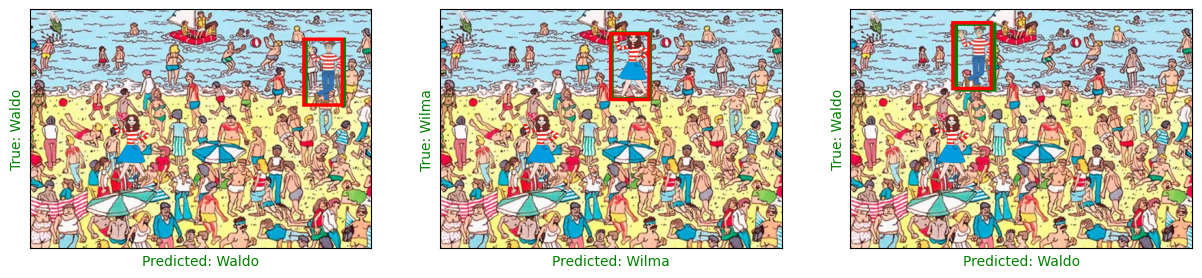

1/1 [==============================] - 0s 127ms/step


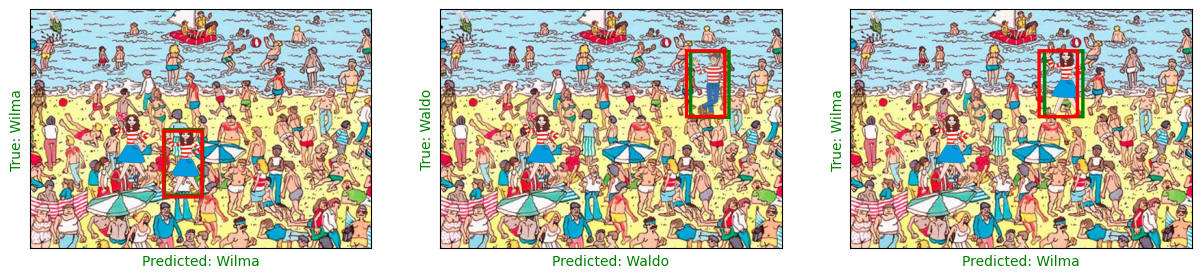

1/1 [==============================] - 0s 129ms/step


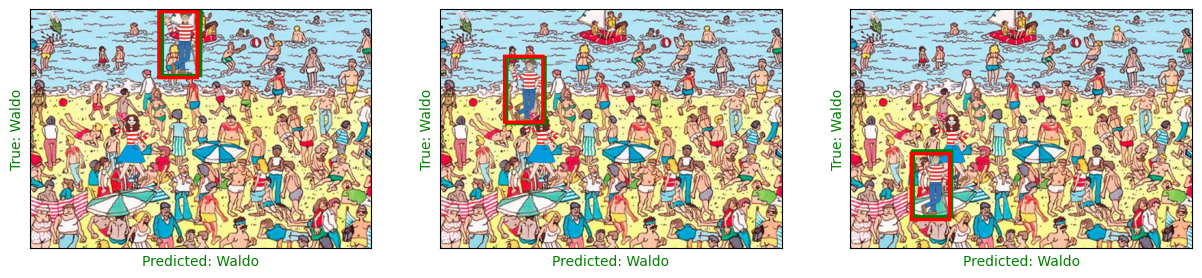

1/1 [==============================] - 0s 138ms/step


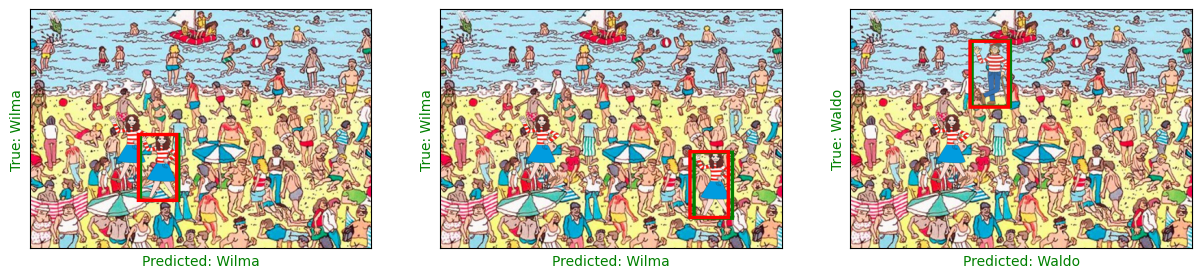

1/1 [==============================] - 0s 215ms/step


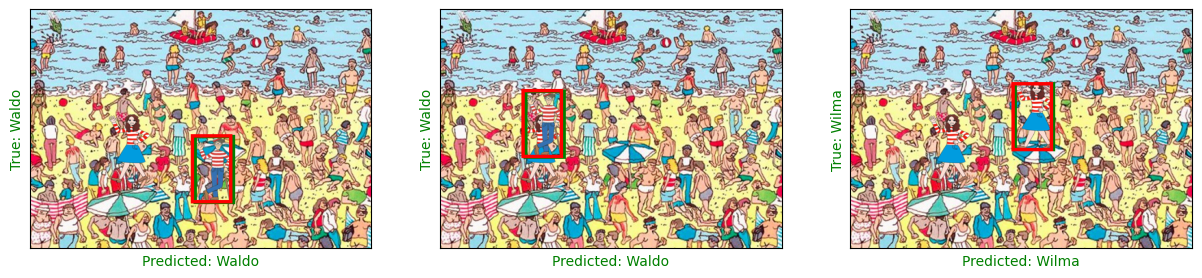

1/1 [==============================] - 0s 195ms/step


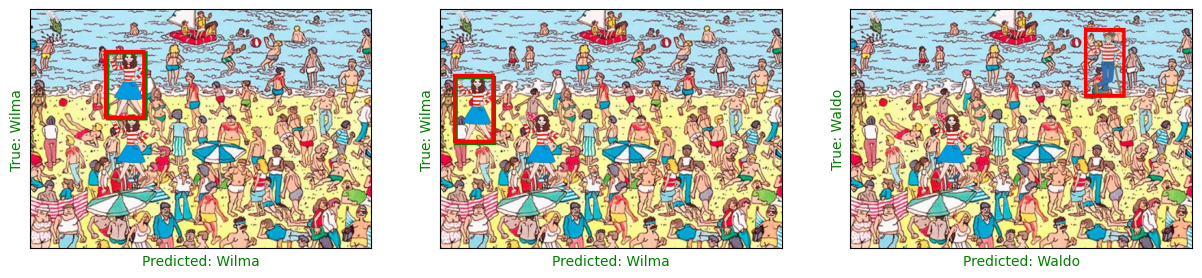

1/1 [==============================] - 0s 127ms/step


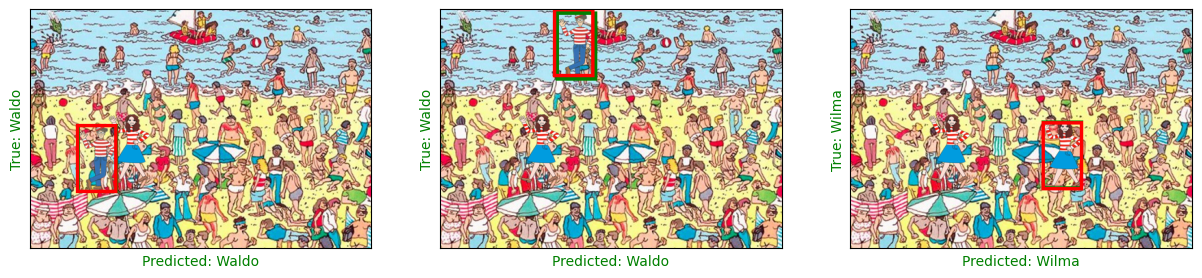

1/1 [==============================] - 0s 130ms/step


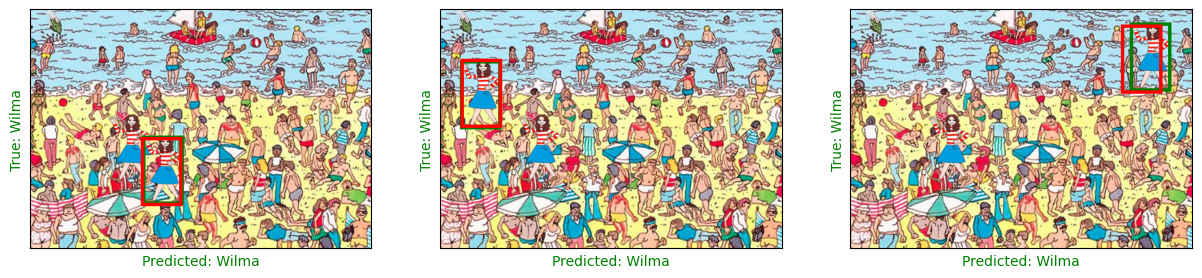

1/1 [==============================] - 0s 144ms/step


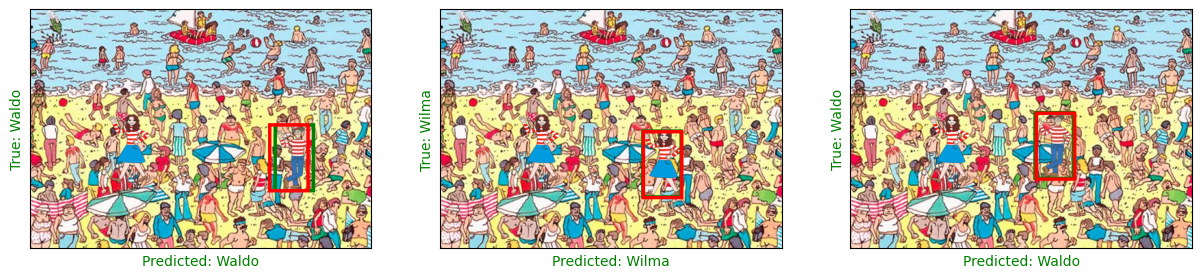

In [37]:
#test again in the end a couple of times
for i in range(10):
    test_model()

In [38]:
test_im=Image.open('generated_images/original_350x500/image_73.png')
plot_im = np.array(test_im).astype('uint8')
test_im = test_im.resize((500, 350))
sample_im=np.array(test_im).astype('uint8')[:,:,:-1]
sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
predicted_class, predicted_box = model.predict(sample_image_normalized)

if predicted_class > 0.5:
    predicted_class = 'Waldo'
else:
    predicted_class = 'Wilma'

print(predicted_class)


1/1 [==============================] - 0s 157ms/step
Waldo


In [52]:
model.save("waldo.h5")


In [44]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [54]:
from tensorflow.keras.models import load_model
loaded_model = load_model('waldo.h5')

In [55]:
test_im=Image.open('generated_images/original_350x500/image_73.png')
plot_im = np.array(test_im).astype('uint8')
test_im = test_im.resize((500, 350))
sample_im=np.array(test_im).astype('uint8')[:,:,:-1]
sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
predicted_class, predicted_box = loaded_model.predict(sample_image_normalized)

if predicted_class > 0.5:
    predicted_class = 'Waldo'
else:
    predicted_class = 'Wilma'

print(predicted_class)

1/1 [==============================] - 0s 475ms/step
Waldo
